<a href="https://colab.research.google.com/github/ilyaleonovStudy/test/blob/main/LR_1_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1
## Регрессионный анализ данных на основе нейросетевых моделей

**Вариант 3**: Набор данных прибыли стартапов  
**Целевой признак**: Profit  
**Модель по варианту**: LSTM  
**Преобразование**: Нормализация

## 1. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}, Colab: {IN_COLAB}')

TensorFlow: 2.19.0, Colab: True


## 2. Загрузка данных

In [2]:
if IN_COLAB:
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])
else:
    df = pd.read_csv('50_Startups.csv')

print(f'Размер: {df.shape}')
df.head()

Saving 50_Startups.csv to 50_Startups.csv
Размер: (50, 5)


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## 3. Разведочный анализ данных (EDA)

### 3.a Описательная статистика

In [3]:
print(f'Типы данных:\n{df.dtypes}\n')
print(f'Пропуски: {df.isnull().sum().sum()}, дубликаты: {df.duplicated().sum()}')
df.describe().round(2)

Типы данных:
R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

Пропуски: 0, дубликаты: 0


,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,73721.62,121344.64,211025.10,112012.64
std,45902.26,28017.80,122290.31,40306.18
min,0.00,51283.14,0.00,14681.40
25%,39936.37,103730.88,129300.13,90138.90
50%,73051.08,122699.80,212716.24,107978.19
75%,101602.80,144842.18,299469.08,139765.98
max,165349.20,182645.56,471784.10,192261.83


In [4]:
print(f'State: {df["State"].value_counts().to_dict()}')

State: {'New York': 17, 'California': 17, 'Florida': 16}


### 3.b Визуализация данных

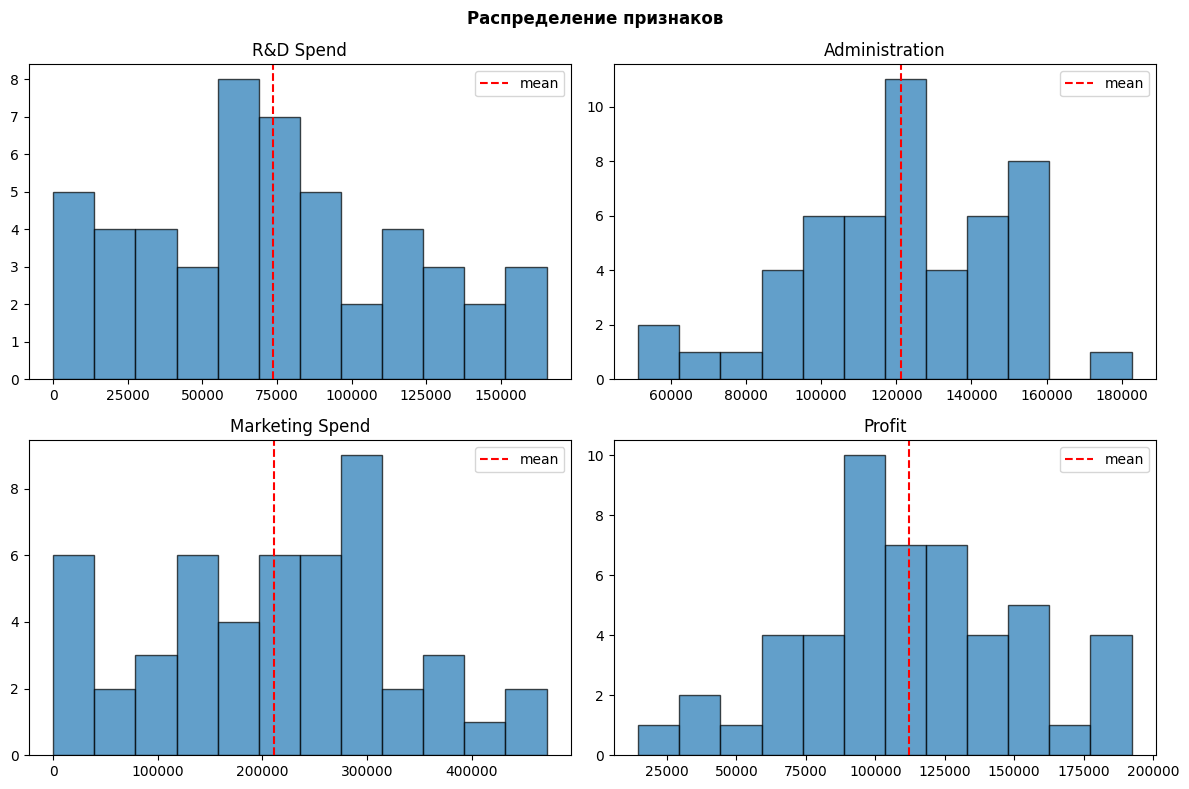

In [5]:
numeric_cols = ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 2, idx % 2]
    ax.hist(df[col], bins=12, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label='mean')
    ax.legend()
plt.suptitle('Распределение признаков', fontweight='bold')
plt.tight_layout()
plt.show()

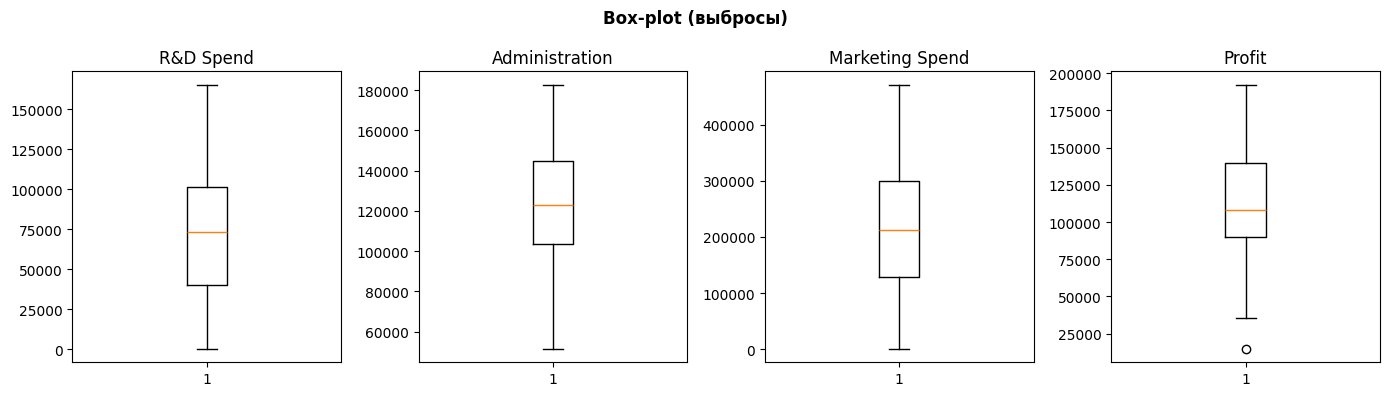

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(col)
plt.suptitle('Box-plot (выбросы)', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.c Очистка данных

In [7]:
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f'{col}: выбросов {len(outliers)}')
print('Очистка не требуется.')

R&D Spend: выбросов 0
Administration: выбросов 0
Marketing Spend: выбросов 0
Profit: выбросов 1
Очистка не требуется.


### 3.d Корреляционный анализ

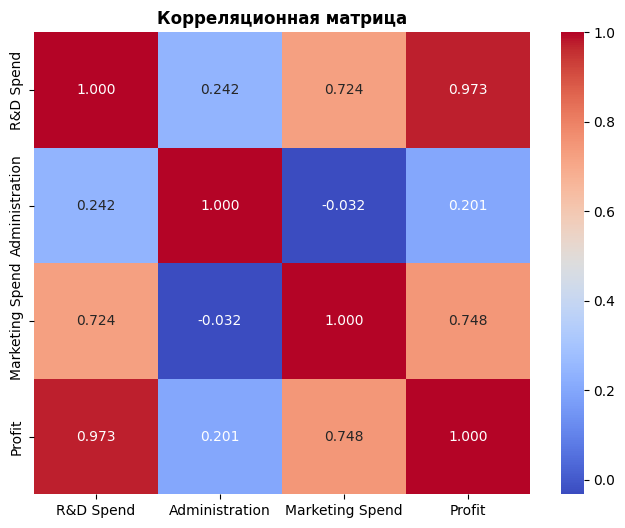

Корреляция с Profit:
R&D Spend          0.973
Marketing Spend    0.748
Administration     0.201
Name: Profit, dtype: float64


In [8]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Корреляционная матрица', fontweight='bold')
plt.show()
print(f'Корреляция с Profit:\n{corr["Profit"].drop("Profit").sort_values(ascending=False).round(3)}')

### 3.e-f Отбор признаков

Признаки с корреляцией > 0.5: R&D Spend, Marketing Spend

In [9]:
selected_features = ['R&D Spend', 'Marketing Spend']
print(f'Отобранные признаки: {selected_features}')

Отобранные признаки: ['R&D Spend', 'Marketing Spend']


### 3.g Преобразование категориальных признаков (OHE)

In [10]:
df_encoded = pd.get_dummies(df, columns=['State'], drop_first=False)
print(f'Столбцы: {df_encoded.columns.tolist()}')

Столбцы: ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit', 'State_California', 'State_Florida', 'State_New York']


### 3.h Подготовка данных

In [11]:
X_original = df_encoded.drop('Profit', axis=1).values.astype(np.float32)
X_selected = df_encoded[selected_features].values.astype(np.float32)
y = df_encoded['Profit'].values.astype(np.float32)
print(f'X_original: {X_original.shape}, X_selected: {X_selected.shape}')

X_original: (50, 6), X_selected: (50, 2)


## 4. Формирование наборов данных

4 набора: исходный, исходный нормализованный, построенный, построенный нормализованный

In [12]:
def create_splits(X, y):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=SEED)
    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}
scalers = {}

for name, X in [('original', X_original), ('selected', X_selected)]:
    X_train, X_val, X_test, y_train, y_val, y_test = create_splits(X, y)
    datasets[name] = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                      'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_n = scaler_X.fit_transform(X_train)
    X_val_n = scaler_X.transform(X_val)
    X_test_n = scaler_X.transform(X_test)
    y_train_n = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
    y_val_n = scaler_y.transform(y_val.reshape(-1,1)).flatten()
    y_test_n = scaler_y.transform(y_test.reshape(-1,1)).flatten()

    datasets[f'{name}_norm'] = {'X_train': X_train_n.astype(np.float32), 'X_val': X_val_n.astype(np.float32),
                                'X_test': X_test_n.astype(np.float32), 'y_train': y_train_n.astype(np.float32),
                                'y_val': y_val_n.astype(np.float32), 'y_test': y_test_n.astype(np.float32)}
    scalers[f'{name}_norm'] = {'y': scaler_y}

print(f'Наборы: {list(datasets.keys())}')
print(f'Train: {datasets["original"]["X_train"].shape[0]}, Val: {datasets["original"]["X_val"].shape[0]}, Test: {datasets["original"]["X_test"].shape[0]}')

Наборы: ['original', 'original_norm', 'selected', 'selected_norm']
Train: 30, Val: 10, Test: 10


## 5. Построение и сравнение моделей

In [13]:
def create_mlp(input_dim):
    model = Sequential([Input(shape=(input_dim,)), Dense(32, activation='relu'), Dense(16, activation='relu'), Dense(1)])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def create_lstm(input_dim):
    model = Sequential([Input(shape=(1, input_dim)), LSTM(32), Dense(16, activation='relu'), Dense(1)])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def calc_metrics(y_true, y_pred, scaler_y=None):
    if scaler_y:
        y_true = scaler_y.inverse_transform(y_true.reshape(-1,1)).flatten()
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
    return np.sqrt(mean_squared_error(y_true, y_pred)), r2_score(y_true, y_pred)

In [14]:
results = []
models_dict = {}

for ds_name, ds in datasets.items():
    is_norm = 'norm' in ds_name
    scaler_y = scalers[ds_name]['y'] if is_norm else None

    for model_type in ['MLP', 'LSTM']:
        input_dim = ds['X_train'].shape[1]
        if model_type == 'MLP':
            model = create_mlp(input_dim)
            X_tr, X_vl = ds['X_train'], ds['X_val']
        else:
            model = create_lstm(input_dim)
            X_tr = ds['X_train'].reshape(-1, 1, input_dim)
            X_vl = ds['X_val'].reshape(-1, 1, input_dim)

        model.fit(X_tr, ds['y_train'], validation_data=(X_vl, ds['y_val']), epochs=100, batch_size=8, verbose=0)
        y_pred = model.predict(X_vl, verbose=0).flatten()
        rmse, r2 = calc_metrics(ds['y_val'], y_pred, scaler_y)

        results.append({'Dataset': ds_name, 'Model': model_type, 'Val_RMSE': rmse, 'Val_R2': r2})
        models_dict[f'{ds_name}_{model_type}'] = {'model': model, 'scaler_y': scaler_y}
        print(f'{ds_name:15} | {model_type}: R2={r2:.4f}, RMSE={rmse:.0f}')

results_df = pd.DataFrame(results)
results_df

original        | MLP: R2=0.7904, RMSE=20509
original        | LSTM: R2=-6.7450, RMSE=124676
original_norm   | MLP: R2=0.8459, RMSE=17584
original_norm   | LSTM: R2=0.9110, RMSE=13361


selected        | MLP: R2=0.6648, RMSE=25939


selected        | LSTM: R2=-6.7446, RMSE=124673
selected_norm   | MLP: R2=0.9502, RMSE=9998
selected_norm   | LSTM: R2=0.9507, RMSE=9944


,Dataset,Model,Val_RMSE,Val_R2
0,original,MLP,20509.285312,0.790418
1,original,LSTM,124676.336680,-6.745008
2,original_norm,MLP,17584.167424,0.845937
3,original_norm,LSTM,13361.459202,0.911047
4,selected,MLP,25938.650081,0.664766
5,selected,LSTM,124673.018476,-6.744596
6,selected_norm,MLP,9998.161431,0.950193
7,selected_norm,LSTM,9944.485507,0.950726


In [15]:
best_idx = results_df['Val_R2'].idxmax()
best = results_df.loc[best_idx]
best_key = f"{best['Dataset']}_{best['Model']}"
print(f'Лучшая модель: {best["Model"]} на {best["Dataset"]}, R2={best["Val_R2"]:.4f}')

Лучшая модель: LSTM на selected_norm, R2=0.9507


## 6. Оценка лучшей модели на тестовом наборе

In [16]:
ds = datasets[best['Dataset']]
model = models_dict[best_key]['model']
scaler_y = models_dict[best_key]['scaler_y']
X_test = ds['X_test'].reshape(-1, 1, ds['X_test'].shape[1]) if best['Model'] == 'LSTM' else ds['X_test']
y_pred = model.predict(X_test, verbose=0).flatten()
test_rmse, test_r2 = calc_metrics(ds['y_test'], y_pred, scaler_y)
print(f'Тест: R2={test_r2:.4f}, RMSE={test_rmse:.0f}')

Тест: R2=0.8769, RMSE=9984


## 7. Grid Search

In [17]:
ds = datasets[best['Dataset']]
scaler_y = scalers[best['Dataset']]['y'] if 'norm' in best['Dataset'] else None
input_dim = ds['X_train'].shape[1]
X_gs = np.vstack([ds['X_train'], ds['X_val']])
y_gs = np.concatenate([ds['y_train'], ds['y_val']])

grid_results = []
for units in [16, 32, 64]:
    for lr in [0.001, 0.01]:
        X_tr, X_vl, y_tr, y_vl = train_test_split(X_gs, y_gs, test_size=0.2, random_state=SEED)
        if best['Model'] == 'MLP':
            m = Sequential([Input(shape=(input_dim,)), Dense(units, activation='relu'), Dense(units//2, activation='relu'), Dense(1)])
        else:
            m = Sequential([Input(shape=(1, input_dim)), LSTM(units), Dense(units//2, activation='relu'), Dense(1)])
            X_tr, X_vl = X_tr.reshape(-1,1,input_dim), X_vl.reshape(-1,1,input_dim)
        m.compile(optimizer=Adam(lr), loss='mse')
        m.fit(X_tr, y_tr, validation_data=(X_vl, y_vl), epochs=100, batch_size=8, verbose=0)
        rmse, r2 = calc_metrics(y_vl, m.predict(X_vl, verbose=0).flatten(), scaler_y)
        grid_results.append({'units': units, 'lr': lr, 'R2': r2, 'RMSE': rmse})

grid_df = pd.DataFrame(grid_results).sort_values('R2', ascending=False)
bp = grid_df.iloc[0]
print(f'Лучшие параметры: units={int(bp["units"])}, lr={bp["lr"]}')
grid_df

Лучшие параметры: units=16, lr=0.01


,units,lr,R2,RMSE
1,16,0.010,0.980814,5096.501938
3,32,0.010,0.962266,7147.332929
4,64,0.001,0.961637,7206.649430
5,64,0.010,0.960781,7286.627478
2,32,0.001,0.953325,7949.124480
0,16,0.001,0.884065,12528.127713


## 8. Оценка после Grid Search

In [18]:
units, lr = int(bp['units']), bp['lr']
if best['Model'] == 'MLP':
    opt_model = Sequential([Input(shape=(input_dim,)), Dense(units, activation='relu'), Dense(units//2, activation='relu'), Dense(1)])
    X_gs_m, X_test_m = X_gs, ds['X_test']
else:
    opt_model = Sequential([Input(shape=(1, input_dim)), LSTM(units), Dense(units//2, activation='relu'), Dense(1)])
    X_gs_m, X_test_m = X_gs.reshape(-1,1,input_dim), ds['X_test'].reshape(-1,1,input_dim)
opt_model.compile(optimizer=Adam(lr), loss='mse')
opt_model.fit(X_gs_m, y_gs, epochs=100, batch_size=8, verbose=0)
opt_rmse, opt_r2 = calc_metrics(ds['y_test'], opt_model.predict(X_test_m, verbose=0).flatten(), scaler_y)

print(f'До:    R2={test_r2:.4f}, RMSE={test_rmse:.0f}')
print(f'После: R2={opt_r2:.4f}, RMSE={opt_rmse:.0f}')

До:    R2=0.8769, RMSE=9984
После: R2=0.9125, RMSE=8417


## 9. Выводы

In [19]:
print(f'''
ВЫВОДЫ:
1. Датасет: 50 стартапов, пропусков нет
2. Корреляция с Profit: R&D Spend (0.97), Marketing Spend (0.75)
3. Лучшая модель: {best["Model"]} на {best["Dataset"]}
4. Тест до оптимизации: R2={test_r2:.4f}
5. Лучшие параметры: units={units}, lr={lr}
6. Тест после оптимизации: R2={opt_r2:.4f}
''')


ВЫВОДЫ:
1. Датасет: 50 стартапов, пропусков нет
2. Корреляция с Profit: R&D Spend (0.97), Marketing Spend (0.75)
3. Лучшая модель: LSTM на selected_norm
4. Тест до оптимизации: R2=0.8769
5. Лучшие параметры: units=16, lr=0.01
6. Тест после оптимизации: R2=0.9125



In [20]:
results_df.round(4)

,Dataset,Model,Val_RMSE,Val_R2
0,original,MLP,20509.2853,0.7904
1,original,LSTM,124676.3367,-6.7450
2,original_norm,MLP,17584.1674,0.8459
3,original_norm,LSTM,13361.4592,0.9110
4,selected,MLP,25938.6501,0.6648
5,selected,LSTM,124673.0185,-6.7446
6,selected_norm,MLP,9998.1614,0.9502
7,selected_norm,LSTM,9944.4855,0.9507
